In [43]:
import seaborn as sns

# Set environment variable for OPENAI_API_KEY in jupyter server
from fc_metric import calculate_fc_using_gpt
import pandas as pd
import matplotlib.pyplot as plt

## You only need the first part of this notebook to run the LM FC metric on the dataset
If you need to analyze an existing ranking, you can skip to second part of the notebook. 

The data can be downloaded from [here](https://github.com/Yale-LILY/SummEval?tab=readme-ov-file#human-annotations)  
Rename it to fit the naming (summ_eval_model_annotations.aligned.jsonl) and place it to the data folder.

In [2]:
df = pd.read_json('../data/eval/summ_eval_model_annotations.aligned.jsonl', lines=True)

In [5]:
df


,id,decoded,expert_annotations,turker_annotations,references,model_id,filepath,average_consistency_evaluation_expert,median_consistency_evaluation_expert
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,"[{'coherence': 2, 'consistency': 1, 'fluency':...","[{'coherence': 3, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,1,1
1,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5
2,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M1,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5
3,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 5, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M14,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5
4,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 4, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 4, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M15,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5
...,...,...,...,...,...,...,...,...,...
1595,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,a timewarp home which has remained unchanged s...,"[{'coherence': 5, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 3, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M0,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5
1596,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"The collector 's paradise in Horfield , Bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 4, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M22,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5
1597,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector’s paradise in horfield , bristol...","[{'coherence': 5, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 4, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M8,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5
1598,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector 's paradise in horfield , bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 3, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M10,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5


Low: paul merson was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . andros townsend scored the tottenham midfielder in the 89th minute . paul merson had another dig at andros townsend after his appearance . the midfielder had been brought on to the england squad last week . click here for all the latest arsenal news news .  
High: paul merson has restarted his row with andros townsend . the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley . andros townsend scores england 's equaliser in their 1-1 friendly draw with italy in turin .  
High: paul merson has restarted his row with andros townsend after the tottenham midfielder was brought on with only seven minutes remaining in his team 's 0-0 draw with burnley on sunday . merson initially angered townsend for writing in his sky sports column that ` if andros townsend can get in -lrb- the england team -rrb- then it opens it up to anybody ' townsend was brought on in the 83rd minute for tottenham as they drew 0-0 against burnley .


In [6]:
df["average_consistency_evaluation_expert"] = df["expert_annotations"].apply(lambda x: round(sum([ measure["consistency"]for measure in x ])/len(x)))
df["median_consistency_evaluation_expert"] = df["expert_annotations"].apply(lambda x: round(sorted([ measure["consistency"]for measure in x ])[len(x)//2]))

In [7]:
df["average_consistency_evaluation_expert"].describe()

count    1600.000000
mean        4.675625
std         0.914291
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: average_consistency_evaluation_expert, dtype: float64

## Running FC Metric batched on the dataset

In [13]:
import os
from openai import OpenAI

if not os.getenv("OPENAI_API_KEY"):
    raise ValueError(
        "Please set the OPENAI_API_KEY environment variable before running the factual consistency metric script"
    )
client = OpenAI()

In [11]:
import json

file_name = f"requests_summ_eval.jsonl"
with open(file_name, "w+") as f:
    for i, row in df.iterrows():
        messages = calculate_fc_using_gpt('; '.join(row["references"]), row["decoded"], False, return_prompt=True)
        input = {
            "custom_id": "row-" + str(i) + "-fc-id-" + str(row["id"]),
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": "gpt-4o-mini",
                "messages": messages
            }
        }
        f.write(json.dumps(input) + "\n")

In [14]:
# Uploading a request file to OpenAI
request_file = client.files.create(
  file=open(file_name, "rb"),
  purpose="batch"
)
request_file

FileObject(id='file-87e2Tq73TZAt7jpMm7gUK5', bytes=6020600, created_at=1733167761, filename='requests_summ_eval.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [15]:
# Creating a batch request using the uploaded input file
batch = client.batches.create(
  input_file_id=request_file.id,
  endpoint="/v1/chat/completions",
  completion_window="24h"
)
batch

Batch(id='batch_674e0ae091148190ba93a3afeb6bbc95', completion_window='24h', created_at=1733167840, endpoint='/v1/chat/completions', input_file_id='file-87e2Tq73TZAt7jpMm7gUK5', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1733254240, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [21]:
batch = client.batches.retrieve(batch.id)
batch

Batch(id='batch_674e0ae091148190ba93a3afeb6bbc95', completion_window='24h', created_at=1733167840, endpoint='/v1/chat/completions', input_file_id='file-87e2Tq73TZAt7jpMm7gUK5', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1733168987, error_file_id=None, errors=None, expired_at=None, expires_at=1733254240, failed_at=None, finalizing_at=1733168880, in_progress_at=1733167841, metadata=None, output_file_id='file-32yCJeweB5LDZs5MxiCCeB', request_counts=BatchRequestCounts(completed=1600, failed=0, total=1600))

In [22]:
response_content = client.files.content(batch.output_file_id)


In [30]:
for line in response_content.iter_lines():
    output = json.loads(line)
    score_json = output['response']["body"]["choices"][0]["message"]["content"]
    score = json.loads(score_json).get("score", -2)
    custom_id = output["custom_id"]
    row_id = int(custom_id.split("-")[1])
    post_id = custom_id.split("-fc-id-")[1]
    if df.loc[row_id, "id"] != post_id:
        raise ValueError(f"Row ID {row_id} does not match post ID {post_id}")
    df.loc[row_id, 'lm_fc_rating'] = score
df

,id,decoded,expert_annotations,turker_annotations,references,model_id,filepath,average_consistency_evaluation_expert,median_consistency_evaluation_expert,lm_fc_rating
0,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson was brought on with only seven min...,"[{'coherence': 2, 'consistency': 1, 'fluency':...","[{'coherence': 3, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M11,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,1,1,2.0
1,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 3, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M13,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5,4.0
2,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M1,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5,4.0
3,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 2, 'consistency': 5, 'fluency':...","[{'coherence': 5, 'consistency': 5, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M14,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5,4.0
4,dm-test-8764fb95bfad8ee849274873a92fb8d6b400eee2,paul merson has restarted his row with andros ...,"[{'coherence': 4, 'consistency': 5, 'fluency':...","[{'coherence': 2, 'consistency': 4, 'fluency':...",[Andros Townsend an 83rd minute sub in Tottenh...,M15,cnndm/dailymail/stories/8764fb95bfad8ee8492748...,5,5,4.0
...,...,...,...,...,...,...,...,...,...,...
1595,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,a timewarp home which has remained unchanged s...,"[{'coherence': 5, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 3, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M0,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5,5.0
1596,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"The collector 's paradise in Horfield , Bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 4, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M22,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5,5.0
1597,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector’s paradise in horfield , bristol...","[{'coherence': 5, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 4, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M8,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5,4.0
1598,dm-test-e880fda4c25289f8325574246f0f8ed4ff5eb26b,"the collector 's paradise in horfield , bristo...","[{'coherence': 3, 'consistency': 5, 'fluency':...","[{'coherence': 4, 'consistency': 3, 'fluency':...",[Nondescript semi-detached home for sale in Ho...,M10,cnndm/dailymail/stories/e880fda4c25289f8325574...,5,5,4.0


In [31]:
df.to_csv("../data/eval/summ_eval_model_annotations.aligned.with_lm_fc.csv")

## Old fashioned individual running:

In [5]:
focus = df.iloc[0:64].copy()


In [6]:
calculate_fc_using_gpt("this is a summary. 12.", "THis is the summary of the summary. It contains the number 12.", fail_silent=False)

3

In [29]:
focus["lm_fc_rating"] = focus.apply(lambda x: calculate_fc_using_gpt("; ".join(x["references"]), x["decoded"], fail_silent=False), axis = 1)
timestamp = pd.Timestamp.now()
focus.to_csv(f"../data/temp_fc_ratings_{timestamp}.csv")

## Use the following code to load previous results and analyze them

In [4]:
#timestamp = 24
df = pd.read_csv(f"../data/eval/summ_eval_model_annotations.aligned.with_lm_fc.csv")

In [32]:
df["lm_fc_rating"].describe()

count    1600.000000
mean        4.043750
std         1.073572
min         1.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: lm_fc_rating, dtype: float64

In [6]:
focus["average_consistency_evaluation_expert"].describe()


count    64.000000
mean      4.718750
std       0.844567
min       1.000000
25%       5.000000
50%       5.000000
75%       5.000000
max       5.000000
Name: average_consistency_evaluation_expert, dtype: float64

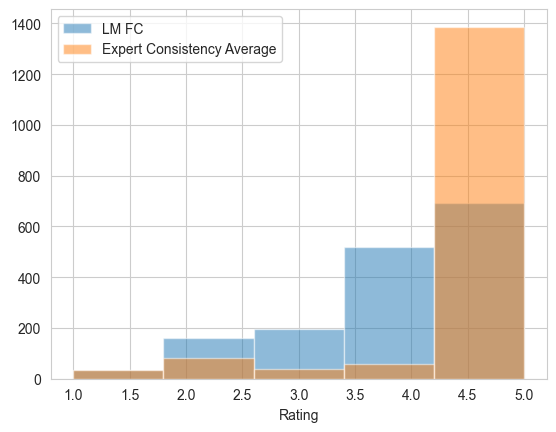

In [33]:
ax1 = df["lm_fc_rating"].hist(
    alpha=0.5,
    bins=5,
    label="LM FC"
)
ax2 = df["average_consistency_evaluation_expert"].hist(
    alpha=0.5,
    bins=5, 
    label="Expert Consistency Average"
)
plt.xlabel("Rating")
plt.legend()
plt.show()

In [34]:
#  Spearman
from scipy.stats import spearmanr

spearmanr(df["lm_fc_rating"], df["average_consistency_evaluation_expert"])

SignificanceResult(statistic=np.float64(0.38896159444248707), pvalue=np.float64(6.122162401277891e-59))

In [35]:
# Pearson
from scipy.stats import pearsonr

pearsonr(df["lm_fc_rating"], df["average_consistency_evaluation_expert"])

PearsonRResult(statistic=np.float64(0.4795804476860899), pvalue=np.float64(8.42513214420449e-93))

In [36]:
# Kendall
from scipy.stats import kendalltau

kendalltau(df["lm_fc_rating"], df["average_consistency_evaluation_expert"])

SignificanceResult(statistic=np.float64(0.3551256012906246), pvalue=np.float64(2.501860383229093e-55))

In [37]:
# calculating the percentage of correct rankings 4 or higher
df["lm_good"] = df["lm_fc_rating"] >= 4
df["expert_good"] = df["average_consistency_evaluation_expert"] >= 4
true_positive = (df["lm_good"] & df["expert_good"]).sum() / len(df)
true_negative = (~df["lm_good"] & ~df["expert_good"]).sum() / len(df)
false_positive = (df["lm_good"] & ~df["expert_good"]).sum() / len(df)
false_negative = (~df["lm_good"] & df["expert_good"]).sum() / len(df)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall


(np.float64(0.9710743801652892), np.float64(0.8125864453665284))

Precision should be interpreted as the  percentage of rankings 4 or higher by the LM, that were also ranked high by experts.  
Recall should be interpreted as the percentage of the good rankings by experts, that the LM also ranked high.

In [47]:
# same as above but for 2 or lower
df["lm_bad"] = df["lm_fc_rating"] <= 2
df["expert_bad"] = df["average_consistency_evaluation_expert"] <= 2
true_positive = (df["lm_bad"] & df["expert_bad"]).sum() / len(df)
true_negative = (~df["lm_bad"] & ~df["expert_bad"]).sum() / len(df)
false_positive = (df["lm_bad"] & ~df["expert_bad"]).sum() / len(df)
false_negative = (~df["lm_bad"] & df["expert_bad"]).sum() / len(df)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
precision, recall

(np.float64(0.37435897435897436), np.float64(0.6239316239316239))

mean abs error: 0.788125
count    1600.000000
mean        0.788125
std         0.908295
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: abs_error, dtype: float64


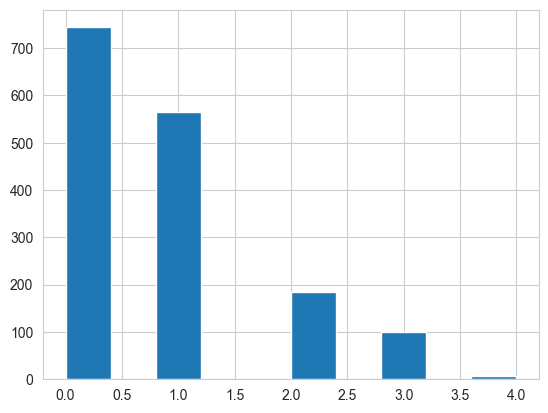

In [39]:
# average distance between predictions
df["abs_error"] = abs(df["lm_fc_rating"] - df["average_consistency_evaluation_expert"])
print("mean abs error:", df["abs_error"].mean())
df["abs_error"].hist()
print(df["abs_error"].describe())

In [41]:
(df["abs_error"] > 2).sum() / len(df)

np.float64(0.066875)

<Axes: xlabel='abs_error', ylabel='Count'>

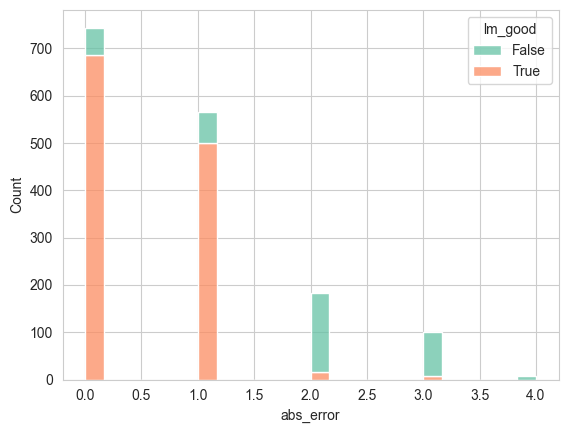

In [49]:
sns.histplot(df, x='abs_error', hue='lm_good', palette='Set2', multiple='stack')